In [154]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
import random
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Model

In [24]:
def evaluate_model(y_pred_train, y_pred_test, y_train, y_test):
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    
    print("MAE train: ", mae_train)
    print("MAE test: ", mae_test)
    print("RMSE train: ", rmse_train)
    print("RMSE test: ", rmse_test)
    print("R2 train: ", r2_train)
    print("R2 test: ", r2_test)

In [25]:
def plot_predictions(y_test_real, y_pred_test_real):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_real, label="Real", color="blue")
    plt.plot(y_pred_test_real, label="Predicho", color="orange")
    plt.title("Predicciones vs. Valores Reales")
    plt.legend()
    plt.show()

In [26]:
def create_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X[i:i + n_steps])
        ys.append(y[i + n_steps])
    return np.array(Xs), np.array(ys)

In [27]:
df = pd.read_csv('../../data/pre_train/gspc.csv', index_col='date')
df.index = pd.to_datetime(df.index)
df = df.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
with tf.keras.utils.custom_object_scope({'mse': MeanSquaredError()}):
    model = load_model('best_model.h5', compile=False)

optimizer = Adam(learning_rate=0.002)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

C:\Users\santi\AppData\Local\Temp\ipykernel_11632\1302470342.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')


In [28]:
X = df.drop(columns=['close', 'log_close'])
y = df['log_close']

In [29]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1, 1))

In [30]:
time_steps = 50
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [31]:
n_features = X_train.shape[2] 

SEED = 1
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [32]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test) 

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [33]:
y_pred_train = y_pred_train.reshape(-1, 1)
y_pred_test = y_pred_test.reshape(-1, 1)

In [34]:
y_train_real = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_train_real = scaler_y.inverse_transform(y_pred_train)
y_pred_test_real = scaler_y.inverse_transform(y_pred_test)

In [35]:
evaluate_model(y_pred_train_real, y_pred_test_real, y_train_real, y_test_real)

MAE train:  0.012807668035203348
MAE test:  0.009558290217265729
RMSE train:  0.017162668455550915
RMSE test:  0.012107069384306005
R2 train:  0.9843452665323783
R2 test:  0.9637558059107205


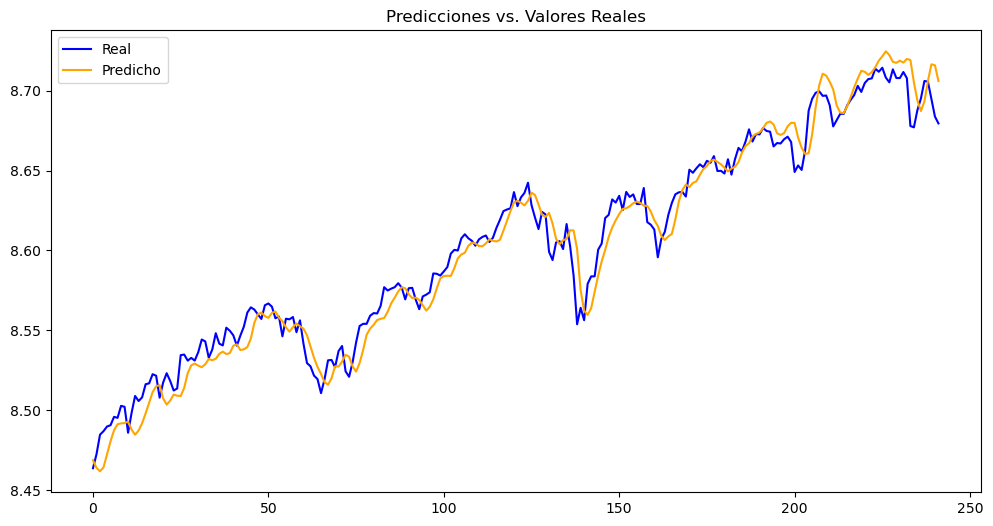

In [36]:
plot_predictions(y_test_real, y_pred_test_real)

# DATA AUGMENTION (dropped)
(worse performance)

### Fine tunning